In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import time
import msgpack
from enum import Enum, auto
import numpy as np

from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local, local_to_global

from planning_utils import get_lat_lon, create_grid, a_star, heuristic, plot_path_on_grid, optimize_path

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 12

In [4]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [5]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        colliders = 'colliders.csv'

        # read lat0, lon0 from colliders into floating point values
        lat0, lon0 = get_lat_lon(colliders)

        print(lat0, lon0)

        # set home position to (lon0, lat0, 0)
        self.set_home_position(lon0, lat0, 0.)

        # retrieve current global position
        global_home_position = (lon0, lat0, 0.)

        # convert to current local position using global_to_local()
        current_local_position = global_to_local(self.global_position, global_home_position)
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt(colliders, delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

        # Define starting point on the grid (this is just grid center)
        # grid_start = (-north_offset, -east_offset)
        # convert start position to current position rather than map center
        grid_start = (int(current_local_position[0] - north_offset),
                      int(current_local_position[1] - east_offset))
#         grid_start = (315, 445)
        
        # Set goal as some arbitrary position on the grid
        # grid_goal = (-north_offset + 50, -east_offset + 20)
        # adapt to set goal as latitude / longitude position and convert
        goal_lon_lat = (-122.39095753, 37.80205495, 0.)
        local_goal_position = global_to_local(goal_lon_lat, global_home_position)
        grid_goal = (int(local_goal_position[0] + north_offset),
                     int(local_goal_position[1] + east_offset))
        
#         lat_long = local_to_global((1066, 565, 0), self.global_home) # -> -122.39095753, 37.80205495
#         print(lat_long)

        # Run A* to find a path from start to goal
        # add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)

        # prune path to minimize number of waypoints
        # (if you're feeling ambitious): Try a different approach altogether!
        path = optimize_path(grid, path)
        
        plot_path_on_grid(grid, path, grid_start, grid_goal)

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]

        # Set self.waypoints
        self.waypoints = waypoints

        # send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()


    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        self.stop_log()

Logs\TLog.txt
Logs\NavLog.txt
starting connection
arming transition
Searching for a path ...
37.79248 -122.39745
global home [0. 0. 0.], position [-1.22397449e+02  3.77924801e+01  8.20000000e-02], local position [ 4.1991605e+06 -1.0879762e+07 -8.2258679e-02]
North offset = -316, east offset = -445
Local Start and Goal:  (316, 445) (750, 119)
Found a path.
prune, then bresenham
94
36

bresenham, then prune
40
31


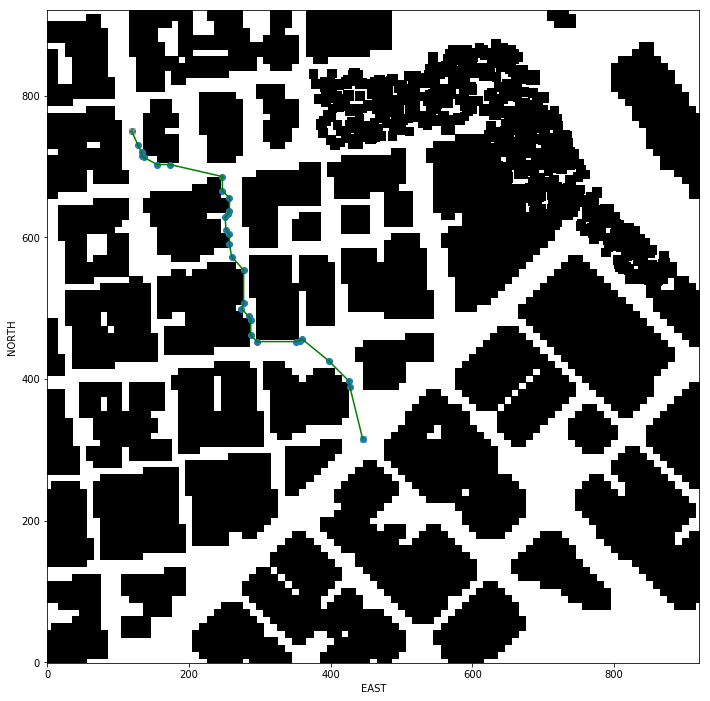

Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
waypoint transition
target position [73, -18, 5, 0]
waypoint transition
target position [81, -19, 5, 0]
waypoint transition
target position [110, -48, 5, 0]
waypoint transition
target position [141, -86, 5, 0]
waypoint transition
target position [138, -89, 5, 0]
waypoint transition
target position [137, -94, 5, 0]
waypoint transition
target position [137, -149, 5, 0]
waypoint transition
target position [146, -158, 5, 0]
waypoint transition
target position [168, -158, 5, 0]
waypoint transition
target position [173, -161, 5, 0]
waypoint transition
target position [183, -171, 5, 0]
waypoint transition
target position [191, -168, 5, 0]
waypoint transition
target position [238, -168, 5, 0]
waypoint transition
target position [257, -185, 5, 0]
waypoint transition
target position [275, -188, 5, 0]
waypoint transition
target position [289, -188, 5, 0]
waypoint transition
target position [295,

In [6]:
conn = MavlinkConnection('tcp:127.0.0.1:5760', timeout=60)
drone = MotionPlanning(conn)
drone.start()